### A. Setups

In [50]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import pandas as pd

import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

from pandas_datareader import data as pdr

from datetime import datetime

plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = "sans-serif"
%matplotlib inline

### B. Data

***Daily closing price of MSFT from 2024-05-14 to 2025-05-14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    251 non-null    object 
 1   Close   251 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB
None
         Date   Close
0  2025-05-14  452.91
1  2025-05-13  449.14
2  2025-05-12  449.26
3  2025-05-09  438.73
4  2025-05-08  438.17


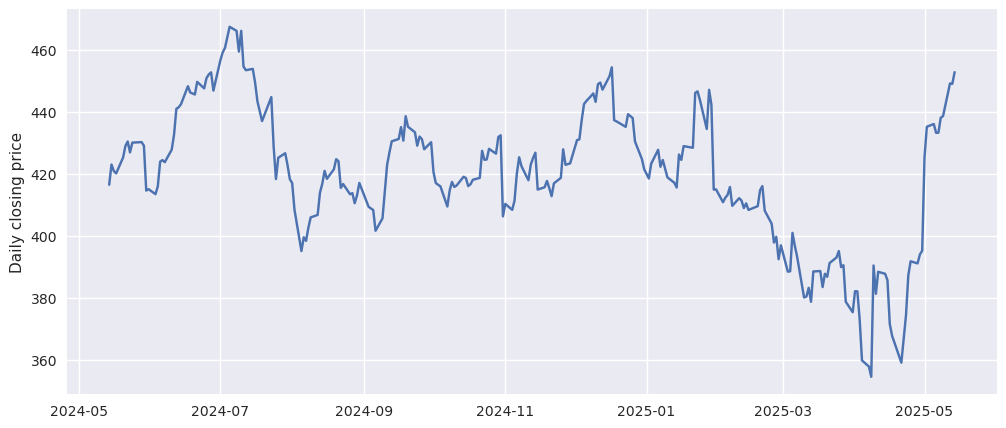

In [36]:
MFST = pd.read_csv('MSFT.csv')
MFST.Date = pd.to_datetime(MFST.Date, dayfirst=False).dt.date

print(f"***Daily closing price of MSFT from {MFST.Date.iloc[-1]} to {MFST.Date.iloc[0]}\n")

print(MFST.info())
print(MFST.head())

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(MFST.Date, MFST.Close)
ax.set_ylabel("Daily closing price")
plt.show(); plt.close()

### C. LSM

In [52]:
def GeneratePaths_Antithetic(nTraj, nStep, T, r, sigma, S0):
    """
    Note: Return a 2D ndarray of the shape 2*NbTraj * (NbStep+1)
    """
    dt = T/nStep
    dW = np.sqrt(dt) * np.random.randn(nTraj, nStep)
    dW = np.vstack((dW, -dW)); nTraj = nTraj*2

    dlnS = (r-(sigma**2)/2)*dt + sigma*dW
    lnS0 = np.log(S0) * np.ones((nTraj, 1))
    lnPaths = np.cumsum(np.hstack((lnS0, dlnS)), axis=1)
    Paths = np.exp(lnPaths)
    return Paths

def element_wise_max(x,y):
    """
    x, y are 1D ndarrays of the same length.
    Note: Return a 1D ndarray of the same length as x and y.
    """
    mat = np.vstack((x,y))
    return np.max(mat, axis=0)

def BasisFunc_Config(S):
    """
    Note:
    S is a 1D ndarray.
    Return the matrix X for regression.
    X is a 2D ndarray.
    """
    Const = np.ones(len(S))
    Basis1 = S
    Basis2 = S**2
    Basis3 = S**3
    X = np.vstack((Const, Basis1,Basis2,Basis3)).T
    return X

class LeastSquare:
    """
    X is a DataFrame.
    y is a Series.
    Output is 
    """
    def __init__(self, BasisFunc_Config, S, y):
        X = BasisFunc_Config(S)
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        self.coefs = model.coef_
        self.fitted = model.predict(X)

def EurPut(SBegin, Strike, T, sigma, r):
    """
    Note:
    r is the annualized continuos risk-free rate.
    sigma is the volatility of stock return per period.
    """
    d1 = (np.log(SBegin/Strike) + (r + 0.5*(sigma**2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = Strike * np.exp(-r * T) * norm.cdf(-d2) - SBegin * norm.cdf(-d1)
    return put_price


    
    
def LSM_Put(SBegin, Strike, T, sigma, r, nStep, nTraj):
    """
    Normalizing method to avoid numerical issue: divide prices and payoffs by the initial price
    Note1: Half of nTraj trajectories are simulated using antithetic method

    Note2:
    r is the annualized continuos risk-free rate.
    nStep is the total time intervals over T.

    Note3: This function return a dictionary of insample result and outsample result.
    """
    S0=1; K=Strike/SBegin
    
    dt=T/nStep
    DiscountFactor = np.exp(-r*T/nStep)

    #In-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    Coef = np.array([np.nan] * nStep, dtype=object)
    
    for t in range(nStep, 0, -1): #t = nStep -> 1
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]
        
        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            regression = LeastSquare(BasisFunc_Config, St[ITM], Realized_PayOff[ITM])
            EPV_PayOff = regression.fitted
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]
            Coef[t] = regression.coefs
        
    InSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin
    
    
    #Out-of-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    
    for t in range(nStep, 0, -1):
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]

        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            EPV_PayOff = BasisFunc_Config(St[ITM]) @ Coef[t]
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]

    OutSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin

    
    res = {"InSample":np.mean(InSample_Realized_PayOff), "OutSample":np.mean(OutSample_Realized_PayOff)}
    return res

In [38]:
#print(EurPut(SBegin=452.91, Strike=1350, T=1, sigma=0.2547, r=0.0203))
#LSM_Put(SBegin=452.91, Strike=455, T=15/250, sigma = 0.2547, r=0.0203, nStep=50, nTraj=50000)["InSample"]

### D. Checking model assumption

<span style="color:blue"> __Log return is stationary__ </span>

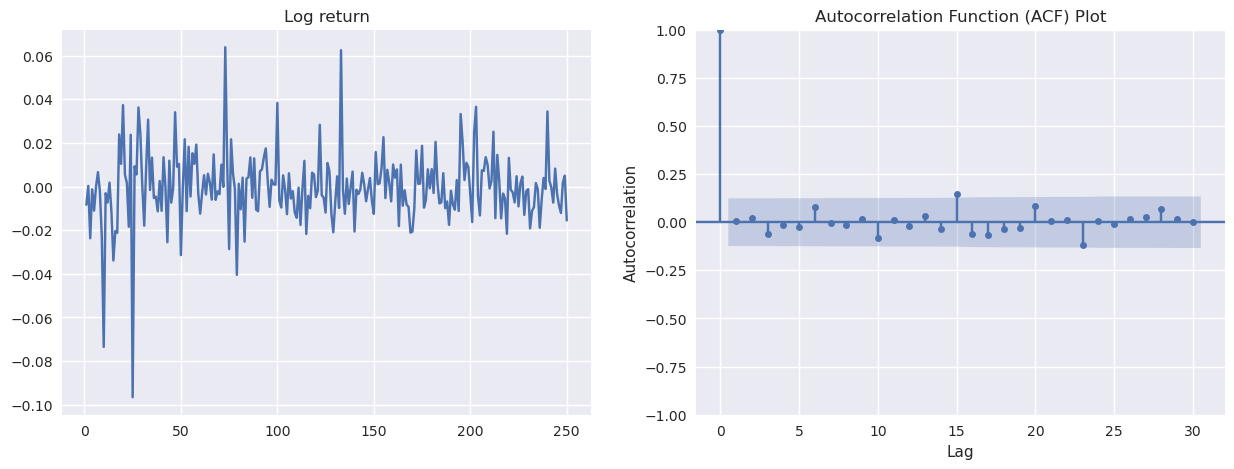

***ADF test:
p_value = 1.7679112656333853e-28
Log return is NOT a Random Walk (stationary).


In [39]:
LogReturn = np.log(MFST.Close/ MFST.Close.shift(1)).dropna()

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax.plot(LogReturn)
ax.set_title("Log return")

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(LogReturn, lags=30, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF) Plot")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")

plt.show(); plt.close()


print("***ADF test:")
adf_result = adfuller(LogReturn)
p_value = adf_result[1]
print("p_value =", p_value)
if p_value > 0.05:
    print("Log return is a Random Walk (non-stationary).")
else:
    print("Log return is NOT a Random Walk (stationary).")

<span style="color:blue"> __Log return is Normally distributed__ </span>

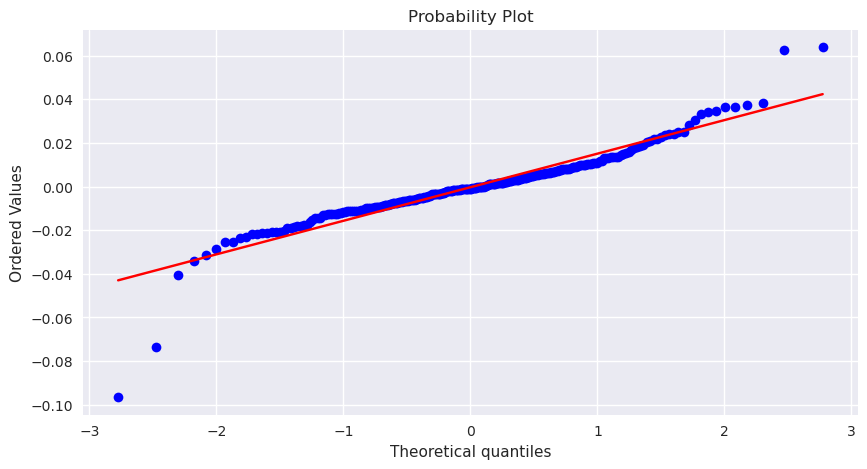

***Jarque-Bera test for Normality:
Jarque-Bera Statistic: 574.0969159785228
P-Value: 2.1698946869046258e-125
Log return is not normally distributed


In [40]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(10,5))
stats.probplot(LogReturn, dist="norm", plot=ax)

plt.show(); plt.close()

print("***Jarque-Bera test for Normality:")
from scipy.stats import jarque_bera
statistic, p_value = jarque_bera(LogReturn)

print(f"Jarque-Bera Statistic: {statistic}")
print(f"P-Value: {p_value}")
if p_value > 0.05:
    print("Log return is normally distributed")
else:
    print("Log return is not normally distributed")

<span style="color:blue"> __Volatility of log return is constant__ </span>

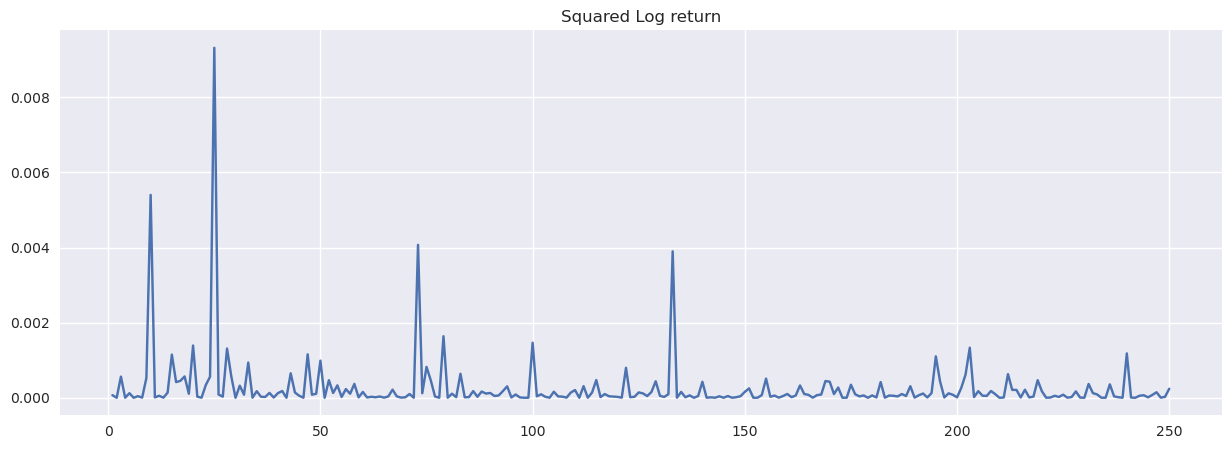

***ARCH-LM test:
ARCH-LM Test statistic: 5.891973991699251
p-value: 0.8242559561476418
volatility is constant


In [41]:

fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(LogReturn**2)
ax.set_title("Squared Log return")
plt.show(); plt.close()

print("***ARCH-LM test:")
from statsmodels.stats.diagnostic import het_arch
# null hypothesis: no ARCH effect (constant volatility)
test_statistic, p_value, _, _ = het_arch(LogReturn, nlags=10) #Note: Input is the residual already

print('ARCH-LM Test statistic:', test_statistic)
print('p-value:', p_value)
if p_value < 0.05:
    print("volitility is not constant")
else:
    print("volatility is constant")

### E. Estimating volatility parameter `sigma` and risk-free rate `r`

***Annualized simple interest rate collected in the secondary market by FRED from 2024-11-14 to 2025-05-14 (181 days):
            DTB4WK
DATE              
2024-11-14    4.52
2024-11-15    4.52
2024-11-18    4.52
2024-11-19    4.49
2024-11-20    4.50
...            ...
2025-05-08    4.23
2025-05-09    4.23
2025-05-12    4.24
2025-05-13    4.25
2025-05-14    4.25

[130 rows x 1 columns]

***Continuosly compounded annualized rate:
Estimate for r (sample mean) = 0.04188658859924648
sample standard deviation = 0.0008795034419096733


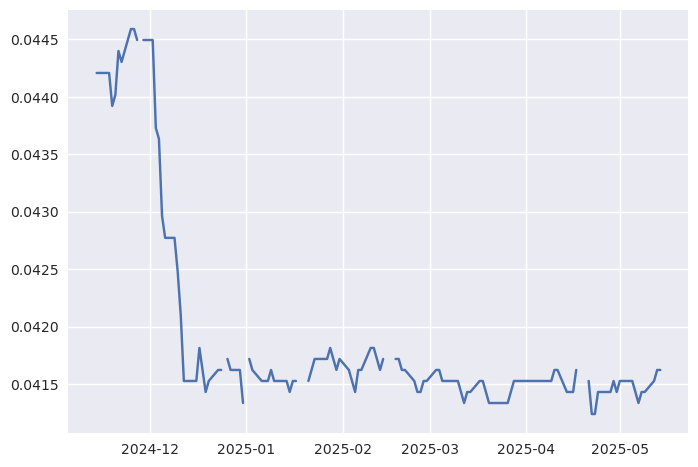

In [42]:
start_date = "2024-11-14"
end_date   = "2025-05-14"
fmt = "%Y-%m-%d"
duration = (datetime.strptime(end_date, fmt) - datetime.strptime(start_date, fmt)).days

Tbill_4w = pdr.DataReader("DTB4WK", "fred", start=start_date, end=end_date)
print(f"***Annualized simple interest rate collected in the secondary market by FRED from {start_date} to {end_date} ({duration} days):")
print(Tbill_4w)

print("\n***Continuosly compounded annualized rate:")
cont_rate = np.log(Tbill_4w.DTB4WK * 0.01 + 1) #Convert to continuosly compounded rate

r = np.mean(cont_rate)
print(f"Estimate for r (sample mean) = {r}")
print(f"sample standard deviation = {np.std(cont_rate)}")

fig, ax = plt.subplots()
ax.plot(cont_rate)
plt.show(); plt.close()

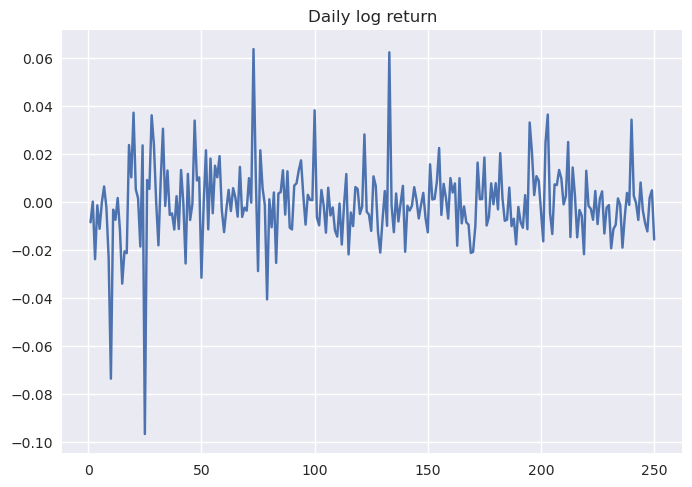

***Estimating sigma (annualized)
Estimate for sigma (sample standard deviation) = 0.255240133164507
SE of the estimate: 0.0007190519083329892


In [43]:
fig, ax = plt.subplots()
ax.plot(LogReturn)
ax.set_title("Daily log return")
plt.show(); plt.close()

print("***Estimating sigma (annualized)")
sigma = np.std(LogReturn) / np.sqrt(1/251)

print("Estimate for sigma (sample standard deviation) =", sigma)
print("SE of the estimate:", np.std(LogReturn) / np.sqrt(2 * 251))

### F. Convergence test

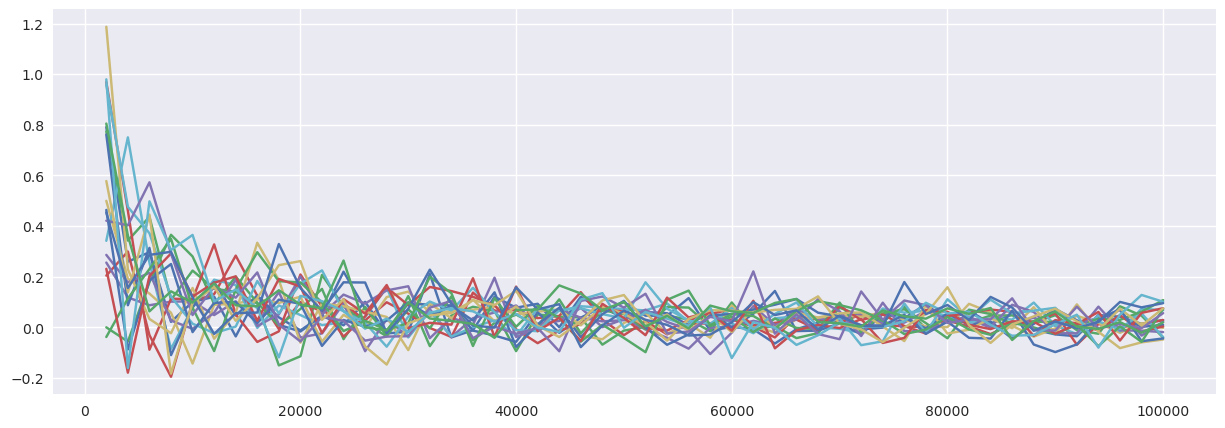

In [44]:
Strike_range = np.linspace(start=455, stop=500, num=20)
nTraj_range = np.arange(1, 51) * 2000
SBegin=MFST.Close[0]; T=15/250; nStep=50

fig, ax = plt.subplots(1,1, figsize=(15,5))

count = 0
for Strike in Strike_range:
    Insamples = np.array([np.nan] * len(nTraj_range))
    Outsamples = np.array([np.nan] * len(nTraj_range))

    for i, nTraj in enumerate(nTraj_range):        
        res = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)
        Insamples[i], Outsamples[i] = res["InSample"], res["OutSample"]
    
    ax.plot(nTraj_range, Insamples - Outsamples)

plt.show(); plt.close()

Comment: Algorithm converge at about 20000 paths

### G. Empirical results

<span style="color:blue"> __Observed values vs LSM values of ITM Amer put on May 14th 2025__ </span>

In [45]:
K = np.array([np.nan] * 9); oVal = np.array([np.nan] * 9)
K[0] = 455; oVal[0] = 5.69
K[1] = 457.5; oVal[1] = 7.6
K[2] = 460; oVal[2] = 9.75
K[3] = 465; oVal[3] = 14.28
K[4] = 470; oVal[4] = 19.2
K[5] = 472.5; oVal[5] = 21.52
K[6] = 485; oVal[6] = 34.2
K[7] = 495; oVal[7] = 44.4
K[8] = 500; oVal[8] = 49
Sigs = np.linspace(start=0.05, stop=1, num=100)

In [46]:
SBegin=MFST.Close[0]; T=15/250; nStep=50; nTraj=20000
nK = 9; nSigs=len(Sigs)

x = np.array([0.0] * nK * nSigs)
y = np.array([0.0] * nK * nSigs)
z = np.array([0.0] * nK * nSigs)

cnt = -1
for i in range(0, nK):
    for j in range(0, nSigs):
        cnt = int(cnt+1)
        Strike = K[i]
        x[cnt] = Sigs[j]; sig = x[cnt]
        y[cnt] = LSM_Put(SBegin, Strike, T, sig, r, nStep, nTraj)["InSample"]
        z[cnt] = Strike

df = pd.DataFrame({"Sigma":x, "Val":y, "Strike":z})

/tmp/ipykernel_2196/3093739366.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


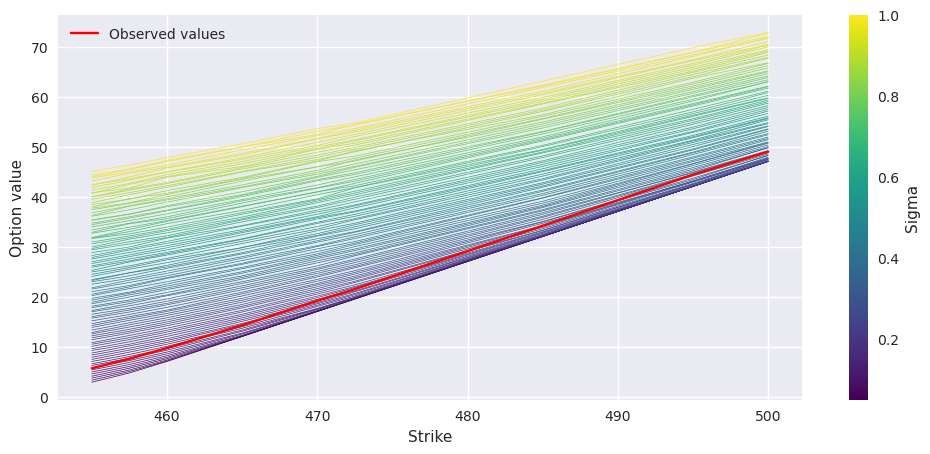

In [47]:

cmap = get_cmap('viridis')
norm = Normalize(vmin=min(Sigs), vmax=max(Sigs))


fig, ax = plt.subplots(figsize=(12,5))
for sig in Sigs:
    color = cmap(norm(sig))
    frame = df[df.Sigma == sig]
    ax.plot(frame.Strike, frame.Val, color=color, linewidth=0.5)

ax.plot(K, oVal, color="r", label="Observed values")
ax.legend()
ax.set_xlabel("Strike")
ax.set_ylabel("Option value")


#Show color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Sigma')

plt.show(); plt.close()

Comment: Model valuation is very sensitive to the parameter sigma.

<span style="color:blue"> __LSM Amer put vs Black-Scholes Eur put at different strike prices__ </span>

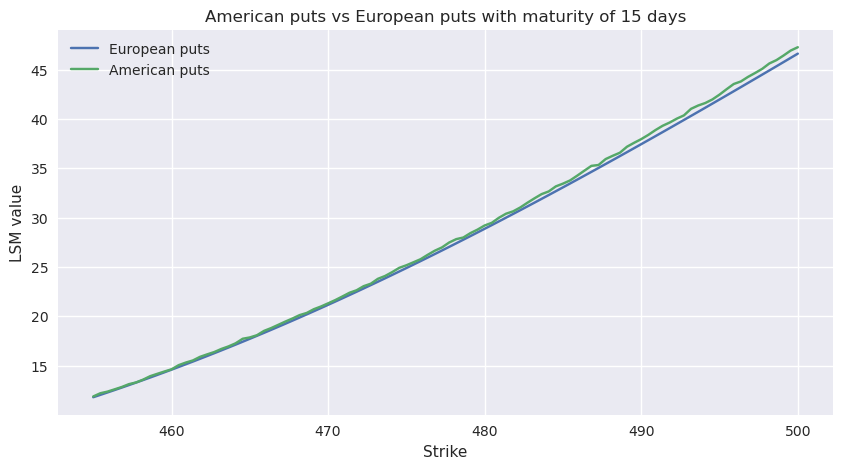

In [53]:
Strike_range = np.linspace(start=455, stop=500, num=100)
Eur_vals = np.array([np.nan] * len(Strike_range))
Amer_vals = np.array([np.nan] * len(Strike_range))

SBegin=MFST.Close[0]; T=15/250; nStep=50; nTraj=20000

for i, Strike in enumerate(Strike_range):    
    Eur_vals[i] = EurPut(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r)
    Amer_vals[i] = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)["InSample"]

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(Strike_range, Eur_vals, label="European puts")
ax.plot(Strike_range, Amer_vals, label="American puts")
ax.set_xlabel("Strike")
ax.set_ylabel("LSM value")
ax.set_title("American puts vs European puts with maturity of 15 days")
ax.legend()
plt.show(); plt.close()

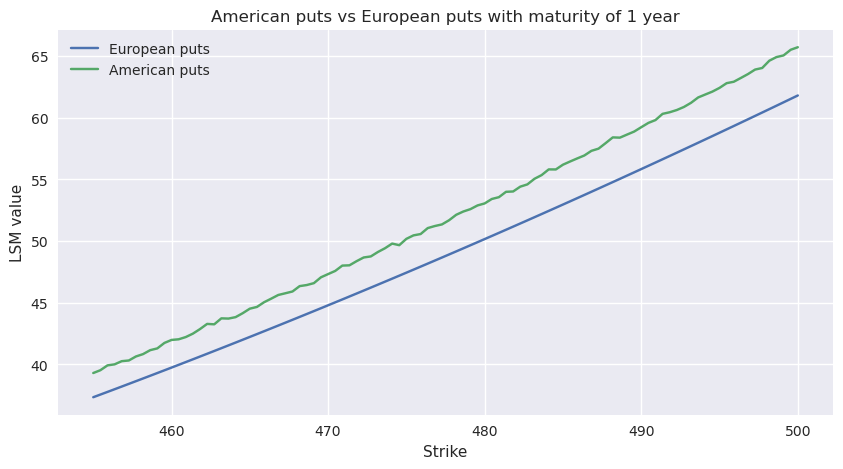

In [54]:
Strike_range = np.linspace(start=455, stop=500, num=100)
Eur_vals = np.array([np.nan] * len(Strike_range))
Amer_vals = np.array([np.nan] * len(Strike_range))

SBegin=MFST.Close[0]; T=1; nStep=100; nTraj=50000


for i, Strike in enumerate(Strike_range):    
    Eur_vals[i] = EurPut(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r)
    Amer_vals[i] = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)["InSample"]

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(Strike_range, Eur_vals, label="European puts")
ax.plot(Strike_range, Amer_vals, label="American puts")
ax.set_xlabel("Strike")
ax.set_ylabel("LSM value")
ax.set_title("American puts vs European puts with maturity of 1 year")
ax.legend()
plt.show(); plt.close()